In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none'

from skimage.morphology import closing, remove_small_objects, label

In [4]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Users/adaly/Documents/mouse_colon/csplotch_anndata'
adata = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_lambdas.h5ad'))

### REPLACE with path to HE image directory downloaded from GCP ###
heimg_dir = '/Users/adaly/Documents/mouse_colon/images'

In [15]:
# Groups cells of same morphological type together
sntypes_map = {
    'Colonocyte': ['Colonocyte'],
    'Immune': ['B', 'T'],
    'Interstitial': ['Fibroblast', 'Glia', 'Lymphatic', 'Macrophage', 'Mesothelial', 'Neuron', 'Vascular'],
    'Muscle': ['SMC'],
    'Epithelial': ['Cycling', 'Enteroendocrine', 'Goblet', 'Stem', 'TA', 'Tuft']
}
sntypes_ordered = (sntypes_map['Immune'] + sntypes_map['Interstitial'] + 
                   sntypes_map['Muscle'] + sntypes_map['Epithelial'] + sntypes_map['Colonocyte'])

# Set colors for each snRNA-seq cell type, ensuring that those sharing a morphological type are drawn from the same colormap.
colors_ordered = []
for snt in sntypes_ordered:
    if snt == 'Colonocyte':
        cmap = matplotlib.cm.get_cmap('Blues')
        colors_ordered.append(cmap(0.75))
    elif snt == 'SMC':
        cmap = matplotlib.cm.get_cmap('Reds')
        colors_ordered.append(cmap(0.75))
    elif snt == 'B' or snt == 'T':
        cmap = matplotlib.cm.get_cmap('Oranges')
        colors_ordered.append(cmap(0.5 * (sntypes_map['Immune'].index(snt)+1) / len(sntypes_map['Immune'])))
    elif snt in sntypes_map['Interstitial']:
        cmap = matplotlib.cm.get_cmap('Greens')
        colors_ordered.append(cmap(0.75 * (sntypes_map['Interstitial'].index(snt)+1) / len(sntypes_map['Interstitial'])))
    elif snt in sntypes_map['Epithelial']:
        cmap = matplotlib.cm.get_cmap('Purples')
        colors_ordered.append(cmap(0.75 * (sntypes_map['Epithelial'].index(snt)+1) / len(sntypes_map['Epithelial'])))
    else:
        raise ValueError('Unrecognized cell type')

### Fig 2b: representative HE image containing spots enriched for celltypes of interest

In [5]:
# Returns inter-spot distance for a classic ST array image cropped to borders of array.
def spot_dist_px(img_shape):
    return 194./(6200./np.min(img_shape[:2])) # Spots in a 6200px-wide image are 194px apart.

# Convert ST array coordinates into pixel coordinates in a given image.
def array_to_px(array_coords, img_shape):
    isd = spot_dist_px(img_shape)

    x_px = (array_coords[:,0]-1) * isd
    y_px = (array_coords[:,1]-1) * isd
    
    return x_px, y_px

# Crop image using a bounding box around specified coordinates.
def crop_img_spots(img, x_px, y_px):
    margin = spot_dist_px(img.shape)
    
    x_min = np.maximum(0, int(np.min(x_px) - margin))
    x_max = np.minimum(int(np.max(x_px) + margin), img.shape[1])
    y_min = np.maximum(0, int(np.min(y_px) - margin))
    y_max = np.minimum(int(np.max(y_px) + margin), img.shape[0])
    
    patch = img[y_min:y_max, x_min:x_max]
    return patch, x_px-x_min, y_px-y_min

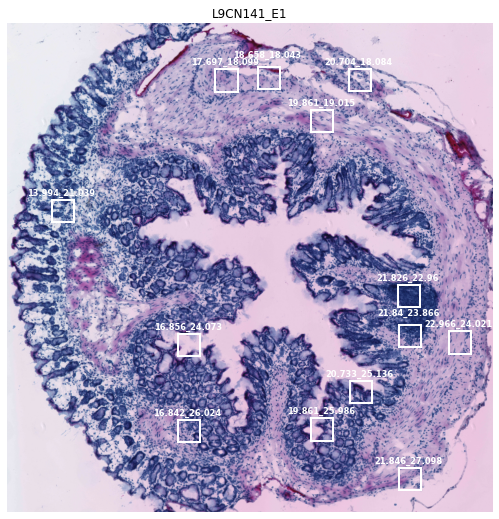

In [10]:
adata.obs['array'] = ['_'.join(Path(x).stem.split('_')[:2]) for x in adata.obs.index.values]

arr_name = 'L9CN141_E1'
obs_arr = adata.obs[adata.obs.array == arr_name]
imfile = os.path.join(heimg_dir, arr_name+'_HE.jpg')

img_arr = np.array(Image.open(imfile))
patch_width = spot_dist_px(img_arr.shape) / 2

fig, ax = plt.subplots(1, figsize=(9,9))
df = pd.read_csv('../data/fig2b_spot_contents.txt')

array_coords_all = np.vstack((df['x'], df['y'])).T
pxx, pxy = array_to_px(array_coords_all, img_arr.shape)
px_coords_all = np.vstack((pxx, pxy)).T

img_crop, xpx_vec, ypx_vec = crop_img_spots(img_arr, px_coords_all[:,0], px_coords_all[:,1])
ax.imshow(img_crop)
ax.axis('off')

# Add bounding boxes around spot locations
for i, (xpx, ypx) in enumerate(zip(xpx_vec, ypx_vec)):
    ax.add_patch(Rectangle((xpx, ypx), patch_width, patch_width, 
                           fill=False, edgecolor='white', lw=2))

    xa, ya = array_coords_all[i,0], array_coords_all[i,1]
    xoff, yoff = 100, -50 
    if ya == 18.043 or ya == 23.866:
        yoff = -100
    ax.text(xpx + xoff, ypx + yoff, '%3g_%3g' % (xa, ya), 
            horizontalalignment='center',
            color='white', fontsize='small', fontweight='bold')

ax.set_title(arr_name)                    
plt.show()

Make pie charts showing the composition of extracted patches in terms of morphological and snrna-seq cell types

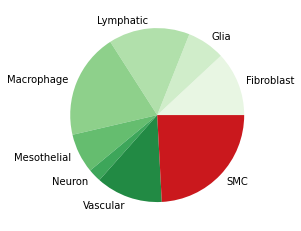

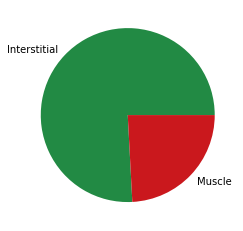

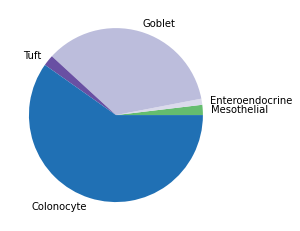

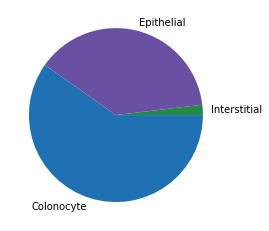

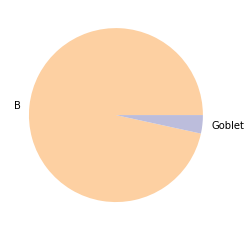

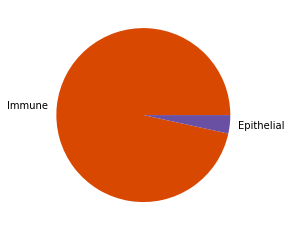

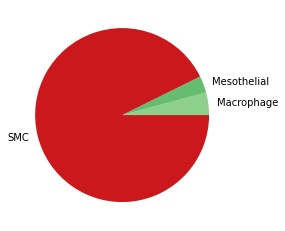

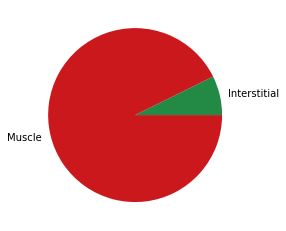

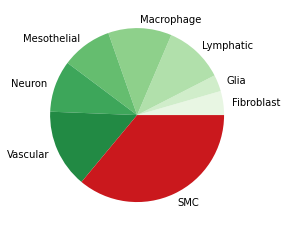

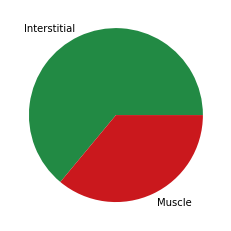

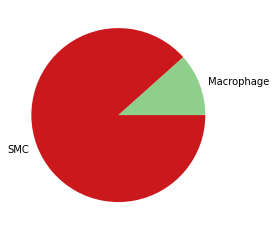

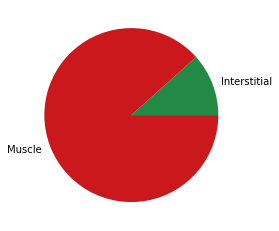

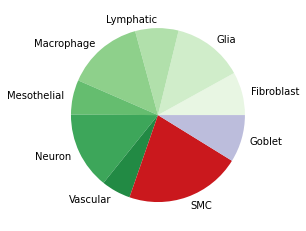

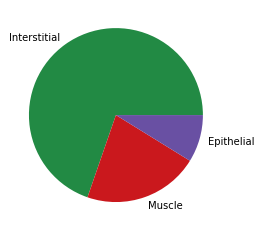

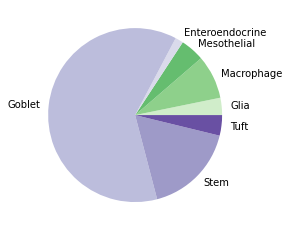

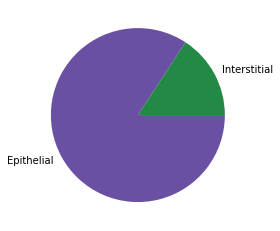

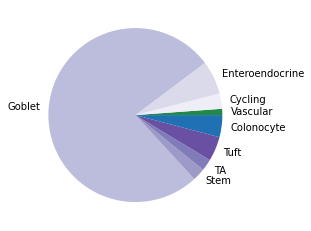

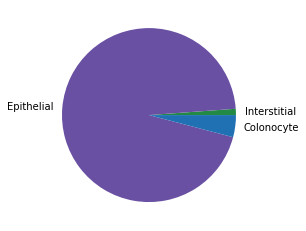

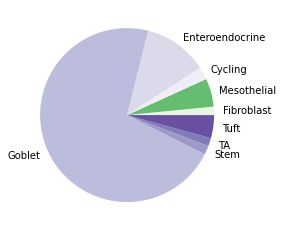

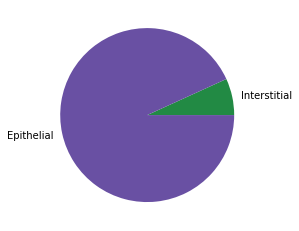

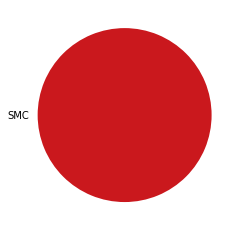

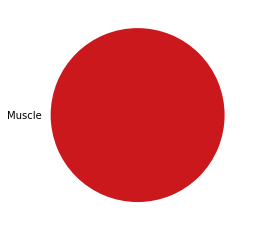

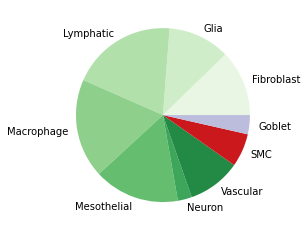

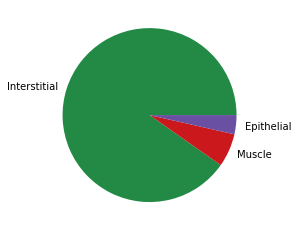

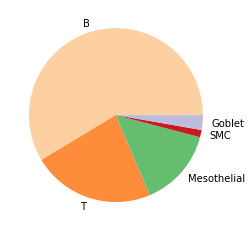

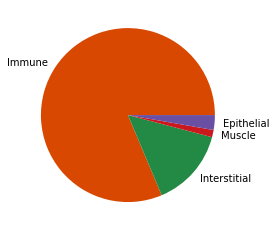

In [17]:
df_comp = obs_arr[np.logical_and(obs_arr['x'].isin(array_coords_all[:,0]), obs_arr['y'].isin(array_coords_all[:,1]))]

for i in range(len(df_comp)):
    row = df_comp.iloc[i]
    x = df_comp.index[i]
    name = x.split('/')[1]
    
    # SPOTlight labels
    comps = np.array([row[ct] for ct in sntypes_ordered])
    labels = np.array(sntypes_ordered)[comps > 0]
    wedges = comps[comps > 0]
    colors = np.array(colors_ordered)[comps > 0]
        
    plt.pie(wedges, labels=labels, colors=colors)
    plt.show()
    
    # Ilastik labels
    m_labels = ['Immune', 'Interstitial', 'Muscle', 'Epithelial', 'Colonocyte']
    m_colors = np.array([matplotlib.cm.get_cmap('Oranges')(0.75),
                         matplotlib.cm.get_cmap('Greens')(0.75),
                         matplotlib.cm.get_cmap('Reds')(0.75),
                         matplotlib.cm.get_cmap('Purples')(0.75),
                         matplotlib.cm.get_cmap('Blues')(0.75)])
                         #'green', 'red', 'purple', 'blue'])
    m_comps = np.zeros(len(m_labels))
    
    for k, mct in enumerate(m_labels):
        inds = np.isin(sntypes_ordered, sntypes_map[mct])
        m_comps[k] = comps[inds].sum()
        
    m_labels = np.array(m_labels)[m_comps > 0]
    m_wedges = m_comps[m_comps > 0]
    m_colors = m_colors[m_comps > 0]
    
    plt.pie(m_wedges, labels=m_labels, colors=m_colors)
    plt.show()

### Fig 2c: mean spot compositions per age group

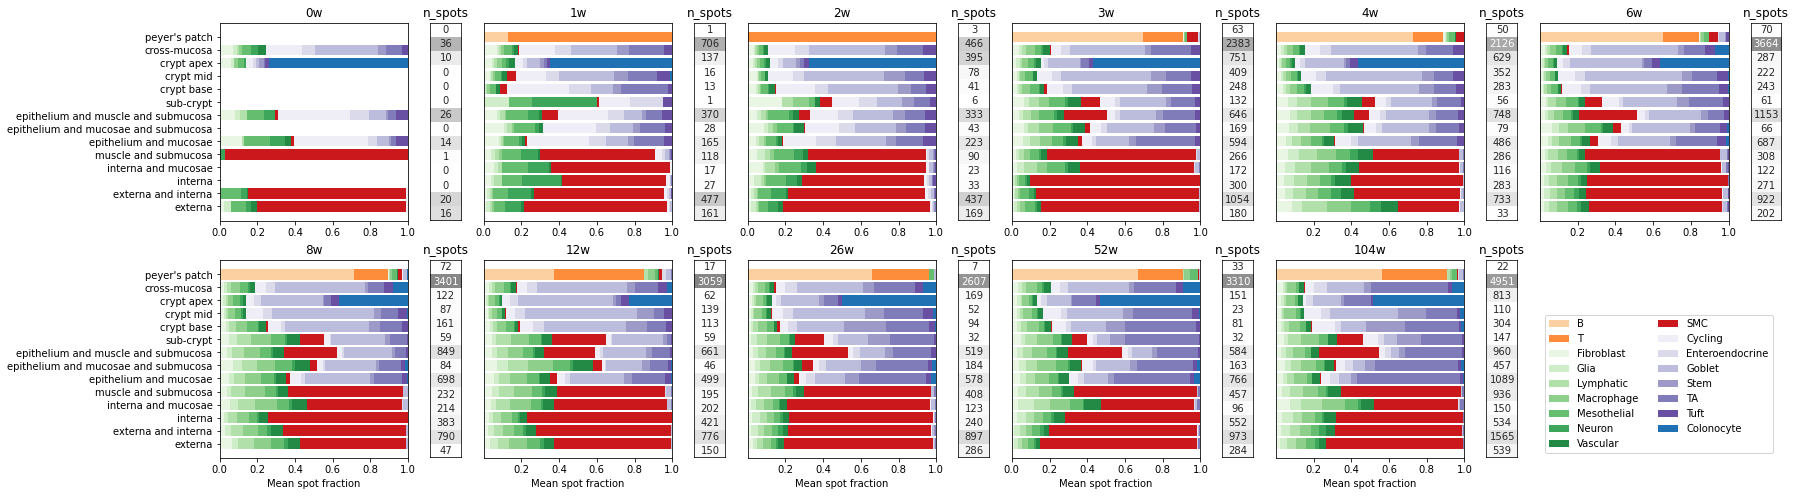

In [21]:
aar_list = ['externa', 'externa and interna', 'interna', 'interna and mucosae', 'muscle and submucosa', 
            'epithelium and mucosae', 'epithelium and mucosae and submucosa',  'epithelium and muscle and submucosa',
            'sub-crypt', 'crypt base', 'crypt mid', 'crypt apex', 'cross-mucosa', "peyer's patch"]
age_list = ['0w', '1w', '2w', '3w', '4w', '6w', '8w', '12w', '26w', '52w', '104w']

N_AAR = len(aar_list)
N_CELLTYPE = len(sntypes_ordered)

fig, ax = plt.subplots(2, 12, figsize=(28, 8), gridspec_kw={'width_ratios': [6,1]*6})

for k, age in enumerate(age_list):
    avg_comp_celltype = np.zeros((N_AAR, N_CELLTYPE))
    obs_age = adata.obs[adata.obs['Age']==age]
    
    axr, axc = k//6, 2*(k%6)
    
    for a, aar in enumerate(aar_list):
        for c, ctype in enumerate(sntypes_ordered):
            if np.sum(obs_age['annotation']==aar) > 0:
                avg_comp_celltype[a, c] = obs_age[obs_age['annotation']==aar][ctype].mean()
    
    # Corner case for instances of 0 spots per AAR -- white bar across plot
    for a, aar in enumerate(aar_list):
        if avg_comp_celltype[a, :].sum() == 0:
            ax[axr, axc].barh(a, 1.0, color='w')
    
    for c, ctype in enumerate(sntypes_ordered):
        if c==0:
            ax[axr, axc].barh(np.arange(N_AAR), avg_comp_celltype[:, c], label=ctype, 
                       color=colors_ordered[c])
        else:
            ax[axr, axc].barh(np.arange(N_AAR), avg_comp_celltype[:, c], label=ctype, 
                       left=avg_comp_celltype[:, :c].sum(axis=1), color=colors_ordered[c])
    
    
    # Note number of spots per age, AAR as a heatmap to the side of each plot
    counts_per_aar = np.expand_dims(np.array([np.sum(obs_age['annotation']==aar) for aar in aar_list], dtype=int), 1)
    normcounts_per_aar = counts_per_aar / counts_per_aar.sum()
    
    sns.heatmap(data=normcounts_per_aar, ax=ax[axr, axc+1], annot=counts_per_aar, 
                cmap='binary', fmt='g', vmin=0, vmax=1, cbar=False)
    # draw black border around 1d heatmap
    ax[axr, axc+1].axvline(0, c='k')
    ax[axr, axc+1].axvline(1, c='k')
    ax[axr, axc+1].axhline(0, c='k')
    ax[axr, axc+1].axhline(len(aar_list), c='k')
    
    ax[axr, axc+1].invert_yaxis()
    ax[axr, axc+1].set_xticks([])
    ax[axr, axc+1].set_yticks([])
    ax[axr, axc+1].set_title('n_spots')
    
    # Label y-axis on left-most plots only
    if axc==0:
        ax[axr, axc].set_yticks(np.arange(N_AAR))
        ax[axr, axc].set_yticklabels(aar_list)
    else:
        ax[axr, axc].set_yticks([])
    
    # Label x-axis on bottom row only
    if axr==0:
        ax[axr, axc].set_xlabel('')
    else:
        ax[axr, axc].set_xlabel('Mean spot fraction')
    
    ax[axr, axc].set_title(age)

ax[axr, axc].legend(bbox_to_anchor=(1.4, 0.0), loc='lower left', ncol=2)
ax[1,10].axis('off')
ax[1,11].axis('off')
plt.show()